In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

def load_inputs():
    # Open and read the “in” Matlab file
    inputs = scipy.io.loadmat(r'.\data\in.mat')

    # Get inputs as numpy array
    inputs = inputs['in']

    return inputs

#### Traces/ measurement matrix: No_inputs X No_samples

In [2]:
def load_traces():
    # Open and read the “traces” Matlab file
    traces = scipy.io.loadmat(r'.\data\traces.mat')

    traces = traces['traces']
    
    return traces

In [3]:
# Read data
inputs = load_inputs()
traces = load_traces()

# 14900 4-bit inputs used in the attack 
no_inputs = np.shape(inputs)[0]

# 14900 traces of 6990 time samples each
no_traces = np.shape(traces)[0]

assert(no_traces == no_inputs)

# Hardcode here the number of power traces to run the attack with
# no_inputs = 500

# Keep only the first 500 traces
# traces = traces[:no_inputs]

In [4]:
def plot_1st_trace():
    plt.plot(traces[0])
    plt.title("Representation of the 1st trace in time")
    plt.xlabel("Power consumption")
    plt.ylabel("Time")
    plt.show()

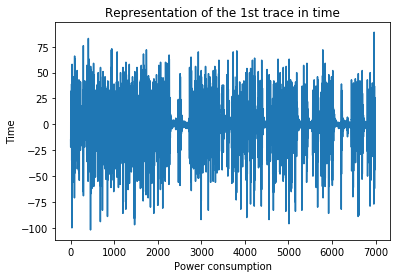

In [5]:
plot_1st_trace()

Each input 4-bit value is XOR'd with a 4-bit secret key (unknown). This is passed through an S-Box (a look-up table). The output of the S-Box will be used to check the guessed value of the key. In this step we will predict all possible values of y, by using in and guessing all the values of the 4-bit key chunk, k.

In [6]:
# Takes a 4-bit value of input and a 4-bit value of the hypothetical key
# Returns the output of the SBox
def SBox(in_val, key):
    return sbox[in_val ^ key]

In [7]:
# 4-bit to 4-bit S-box in PRESENT cipher
#       0   1   2   3   4   5   6   7   8   9   a   b   c   d   e   f
sbox= (0xc,0x5,0x6,0xb,0x9,0x0,0xa,0xd,0x3,0xe,0xf,0x8,0x4,0x7,0x1,0x2)

Calculate the Hamming Weight of the guess.
Convert every possible value 0-16 to binary and count the 1s.
Store in HammingWeight look-up table.

In [8]:
HammingWeight = [bin(n).count('1') for n in range(0,16)]
HammingWeight

[0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4]

#### Construct the power-prediction matrix (hypothetical power consumption), by applying Hemming Weight to the value-prediction matrix values. 
Value-prediction matrix on variable y: No_inputs X No_keys.
Save the hypothetical values for each associated plaintext (input) with each possible guess (16 guesses in total).

In [9]:
def get_power_prediction_matrix(no_inputs):
    # Initialize power prediction matrix
    power_pred = np.zeros(shape=(no_inputs, 16))

    for i in range(no_inputs):
        for key in range(0, 16):
            power_pred[i][key] = HammingWeight[SBox(inputs[i][0], key)]

    np.shape(power_pred)  
    
    return power_pred

In [10]:
# Run the attack with 500, 1k, 2k 4k, 8k and 12k power traces
# For every attack, rank the candidates from best to worst. 
# Plot the correct candidate’s ranking (e.g. 1st, 2nd etc.) for all these attacks.
# no_inputs = 500

power_pred = get_power_prediction_matrix(no_inputs)

In [11]:
power_pred

array([[2., 2., 2., ..., 3., 1., 1.],
       [2., 3., 4., ..., 0., 2., 3.],
       [3., 2., 1., ..., 2., 3., 2.],
       ...,
       [2., 3., 2., ..., 1., 1., 3.],
       [2., 3., 2., ..., 1., 1., 3.],
       [2., 0., 2., ..., 3., 4., 1.]])

#### For all possible k candidates, compute the column-wise correlation between the traces matrix and the power-prediction matrix. Every guess will be compared to all traces.
#### Pearson Correlation Formula:
$ r = \frac{{}\sum_{i=1}^{n} (h_i - \overline{h})(t_i - \overline{t})}
{\sqrt{\sum_{i=1}^{n} (h_i - \overline{t})^2(t_i - \overline{t})^2}} $

Where: 
    <ul>
    <li> i - i iterates over the traces </li>
    <li> h - hypothetical values (from power prediction matrix) </li>
    <li> t - trace values (traces/ measurement matrix) </li>
    </ul>

We will use numpy.corrcoef to obtain the Pearson correlation coefficients.
Ref: https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html

In [12]:
def correlate_traces_with_hypotheses(traces, power_pred):
    no_col_traces = np.shape(traces)[1]
    no_col_power_pred = 16 # 16 key guesses (0..15)
    
    correlation = np.zeros(shape=(no_col_power_pred, no_col_traces))
    
    # Compute correlation between columns
    for power_pred_col in range(no_col_power_pred): # hypothetical values for the guess keys
        for traces_col in range(no_col_traces): # real values
            correlation[power_pred_col, traces_col] = np.corrcoef(power_pred[:,power_pred_col], traces[:,traces_col], rowvar=1)[0][1]
            
    return correlation   

In [13]:
# traces 14900 X 6990
np.shape(traces)
# power_pred 149000 X 16
np.shape(power_pred)

# absolute candidates 16 X 6990
abs_candidates = abs(correlate_traces_with_hypotheses(traces, power_pred))

In [14]:
abs_candidates

array([[0.01029502, 0.00253465, 0.00106446, ..., 0.00582373, 0.00056766,
        0.00394233],
       [0.00148743, 0.00081269, 0.00034324, ..., 0.01066925, 0.00461366,
        0.00778674],
       [0.01262911, 0.00751804, 0.00634696, ..., 0.00428974, 0.01389553,
        0.01188856],
       ...,
       [0.00042684, 0.00082558, 0.00091989, ..., 0.00773322, 0.00730884,
        0.0079668 ],
       [0.0083595 , 0.00788109, 0.00858419, ..., 0.0032777 , 0.00496531,
        0.01547352],
       [0.00346547, 0.00451713, 0.0032943 , ..., 0.01040658, 0.00396858,
        0.00081103]])

In [17]:
def get_top_candidate(candidates):       
    # The top candidate will be chosen based on absolute correlation.
    # The highest correlation reveals the actual KEY.
    candidates_max = np.zeros(16)
    
    # Only store the maximum cpa across all points in the trace 16 X 1
    for i in range(16):
        candidates_max[i] = max(candidates[i])
        
    # Rank the key candidates from best to worst, based on the absolute value of the correlation function.
    print('Top candidates: ', candidates_max.argsort()[::-1][:])
    
    # The highest correlation value reveals the key
    top_candidate_row = np.argmax(candidates_max)
    
    return top_candidate_row

In [18]:
top_candidate = get_top_candidate(abs_candidates)

Top candidates:  [ 6 13  0  5 12 10  4  8  3  7 14 15  9  1 11  2]


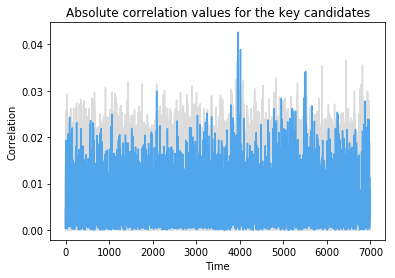

In [21]:
# For every time sample, plot the absolute correlation value for every k candidate
plt.figure()

for i in range(np.shape(abs_candidates)[0]): # 16 candidate keys
        if (i == top_candidate):
            plt.plot(abs_candidates[i], color= '#51A5EB', zorder=2)
        else:
            plt.plot(abs_candidates[i], color = '#DCDCDC', zorder=1)
        
plt.title("Absolute correlation values for the key candidates")
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.show()